## Under-sampling Method Comparison

We will compare how the different under-sampling algorithms discussed in this section improve (or not) the performance of Random Forests on different datasets with imbalanced classes.

### Important

- We train the models on a portion of the data that is under-sampled
- We evaluate the model performance on another portion of the data that **was not resampled**, and thus contains the original class distribution.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    # here I set up a Logistic regression but remember
    # that the authors of this technique concluded that it is best
    # to use the same classifier that will be used to train the final
    # model, so in our case, we should have used a Random Forest
    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance for each dataset

# this is to get a tiny bit familiar with the
# datasets

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4,
    )
    
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    
    # NOTE: that this function returns the ROC over the test set
    # which is the portion of the data that would not be under-sampled
    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# loop to train models with the different under-sampling methods
# over the different datasets

# to save the results
results_dict = {}
shapes_dict = {}

# for each dataset
for dataset in datasets_ls:
    
    # start a new dictionary per dataset
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,  
        data.target, 
        test_size=0.3,
        random_state=0,
    )
    
    # as many undersampling techniques use KNN
    # we put the variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
        
    # train a model on the original data without under-sampling
    # and determine model performance
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    # now, we test the different under-samplers, 1 at a time
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # resample the train set only
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        # train model and evaluate performance
        
        # Note the performance returned is using the
        # test set, which was not under-sampled
        
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        # store results
        results_dict[dataset][undersampler] = roc
        shapes_dict[dataset][undersampler] = len(X_resampled)
        print()
        
    print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9765820711450264
Test set
Random Forests roc-auc: 0.9682620675579141

random
Train set
Random Forests roc-auc: 0.9963001503063939
Test set
Random Forests roc-auc: 0.9897438514134096

cnn
Train set
Random Forests roc-auc: 0.9682002467830072
Test set
Random Forests roc-auc: 0.986376160832738

tomek
Train set
Random Forests roc-auc: 0.980435542098521
Test set
Random Forests roc-auc: 0.973288090621492

oss
Train set
Random Forests roc-auc: 0.9788177918796639
Test set
Random Forests roc-auc: 0.9683130931727727

enn
Train set
Random Forests roc-auc: 0.9864826470845354
Test set
Random Forests roc-auc: 0.9644351464435147

renn
Train set
Random Forests roc-auc: 0.9958987301837685
Test set
Random Forests roc-auc: 0.9692315542402286

allknn
Train set
Random Forests roc-auc: 0.9904645972813958
Test set
Random Forests roc-auc: 0.9684151444024901

ncr
Train set
Random Forests roc-auc: 0.9799498012559451
Test set
Random Forests roc-auc: 0.96744565772017

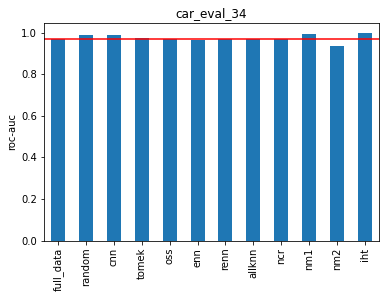

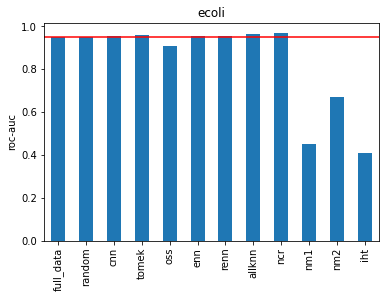

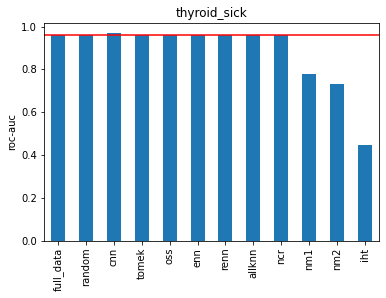

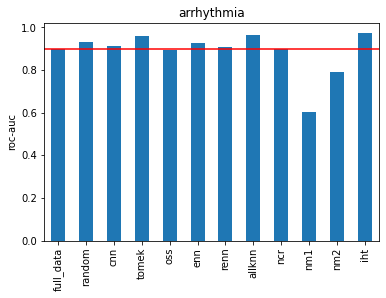

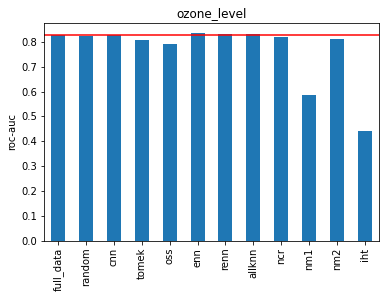

In [7]:
# Print the performance of the models trained with 
# the different under-sampling methods

for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

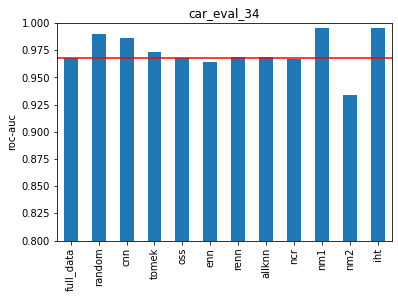

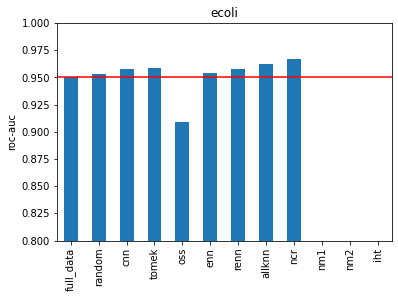

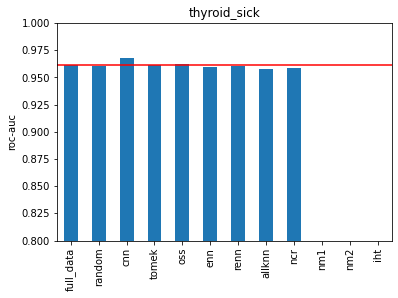

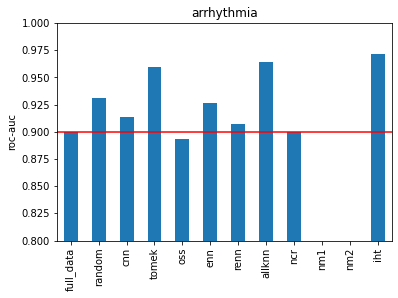

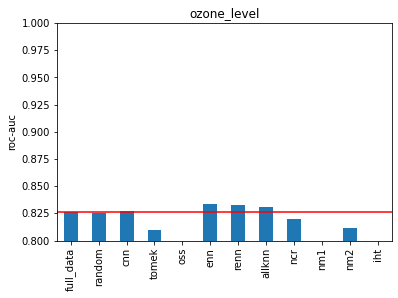

In [8]:
# same as above but with a narrower scale for visibility

for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    
    # this bit of code to modify the y axis scale
    plt.ylim(0.8, 1)
    
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

**CONCLUSION**: Different under-sampling techniques work best for different datasets.

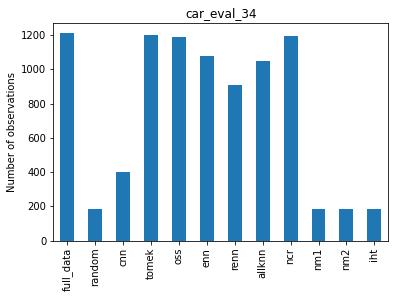

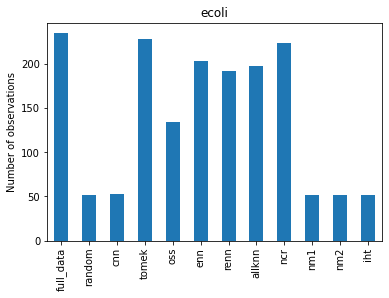

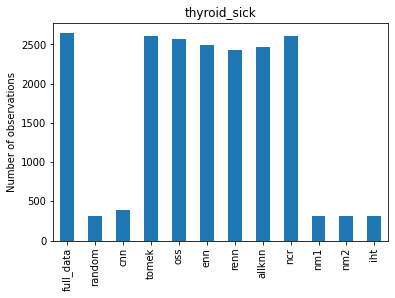

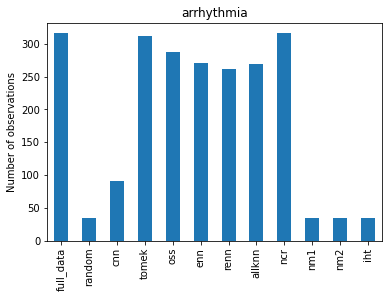

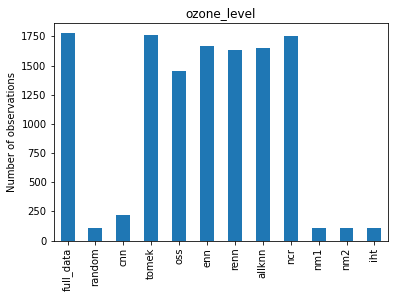

In [9]:
# To finish, I plot the shapes of the datasets after the
# different under-sampling methods were applied, for comparison

# note that the fixed methods (undersampling, near miss and
# instance hardness threshold) return the smallest datasets

# and from the cleaning methods, the Condensed nearest neighbours are 
# the more aggressive at the time of removing samples from the data

for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()